In [11]:
import geopandas as gpd

# Load your GeoJSON file
gdf = gpd.read_file("/Users/caro/Desktop/thesis_project/segregation_indices/data/geometries_and_rent.geojson").head(21)

# Select relevant columns (ID and rent data)
gdf[['ID', 'Total']].to_csv("/Users/caro/Desktop/thesis_project/segregation_indices/data/geometries_and_rent.csv", index=False)


In [12]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/Users/caro/Desktop/thesis_project/segregation_indices/data/geometries_and_rent.csv").head(21)

# Save the file without the header
df.to_csv("/Users/caro/Desktop/thesis_project/segregation_indices/data/geometries_and_rent_no_header.csv", index=False, header=False)


In [18]:
import pandas as pd

# Load the rent data without header
df = pd.read_csv("/Users/caro/Desktop/thesis_project/segregation_indices/data/geometries_and_rent_no_header.csv", header=None, names=['ID', 'Rent'])

# Normalize the rent values to a range (0 to 1)
df['Rent_scaled'] = (df['Rent'] - df['Rent'].min()) / (df['Rent'].max() - df['Rent'].min())

# Save the scaled rent data to a new CSV file
df[['ID', 'Rent_scaled']].to_csv("/Users/caro/Desktop/thesis_project/segregation_indices/data/geometries_and_rent_scaled.csv", index=False, header=False)


In [14]:
gdf

,Indicadores de renta media y mediana,Periodo,Total,ID,geometry
0,Renta neta media por persona,2021,19.199,2807901,"POLYGON ((440598.916 4473021.501, 440521.387 4..."
1,Renta neta media por persona,2021,20.103,2807902,"POLYGON ((441868.350 4470574.975, 441687.915 4..."
2,Renta neta media por persona,2021,23.925,2807903,"POLYGON ((443284.243 4472327.462, 443199.459 4..."
3,Renta neta media por persona,2021,25.956,2807904,"POLYGON ((441815.427 4474666.996, 441573.366 4..."
4,Renta neta media por persona,2021,28.233,2807905,"POLYGON ((443449.166 4477025.984, 443310.072 4..."
5,Renta neta media por persona,2021,17.026,2807906,"POLYGON ((440125.813 4477607.030, 440057.624 4..."
6,Renta neta media por persona,2021,25.275,2807907,"POLYGON ((441494.221 4475491.504, 441458.908 4..."
7,Renta neta media por persona,2021,20.671,2807908,"MULTIPOLYGON (((441547.578 4474113.495, 441546..."
8,Renta neta media por persona,2021,24.659,2807909,"POLYGON ((438923.471 4474651.529, 438911.320 4..."
9,Renta neta media por persona,2021,13.719,2807910,"POLYGON ((435289.562 4469395.541, 435228.959 4..."


In [ ]:
''' 
python /Users/caro/Desktop/thesis_project/ethnic-segregation-rw/get_adjacent_polygons.py \
/Users/caro/Desktop/thesis_project/mobility_data/ZONIFICACION/distritos/madrid_gdf.geojson \
ID \
/Users/caro/Desktop/thesis_project/segregation_indices/data/geometries_and_rent.csv \
> /Users/caro/Desktop/thesis_project/ethnic-segregation-rw/edges.txt
    
'''

'''
python /Users/caro/Desktop/thesis_project/ethnic-segregation-rw/rw_cct_fnt.py \
/Users/caro/Desktop/thesis_project/ethnic-segregation-rw/edges.txt \
/Users/caro/Desktop/thesis_project/segregation_indices/data/geometries_and_rent_scaled.csv \
5000 0-21 \
> /Users/caro/Desktop/thesis_project/ethnic-segregation-rw/results.txt
''' 

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_62711/2740773146.py:14: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf.plot(column="CCT", cmap="coolwarm", legend=True)


<function matplotlib.pyplot.show(close=None, block=None)>

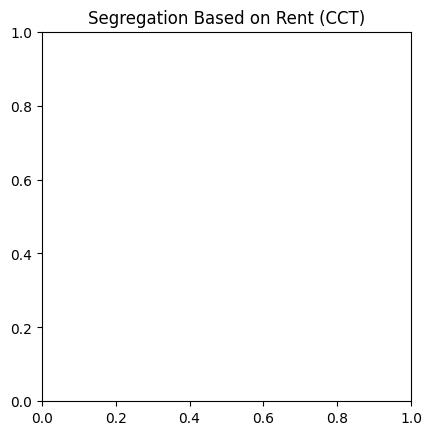

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the district geometries
gdf = gpd.read_file("/Users/caro/Desktop/thesis_project/mobility_data/ZONIFICACION/distritos/madrid_gdf.geojson")

# Assuming you have the CCT results for each district in 'results.txt'
results = pd.read_csv("/Users/caro/Desktop/thesis_project/ethnic-segregation-rw/results.txt", header=None, names=['ID', 'CCT'])

# Merge the CCT results with the GeoDataFrame
gdf = gdf.merge(results, on="ID")

# Plot the map
gdf.plot(column="CCT", cmap="coolwarm", legend=True)
plt.title("Segregation Based on Rent (CCT)")
plt.show


In [17]:
results

,ID,CCT
0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,NaN
1,1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,NaN
2,2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,NaN
3,3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,NaN
4,4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,NaN
5,5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,NaN
6,6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,NaN
7,7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,NaN
8,8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,NaN
9,9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,NaN
